<a href="https://colab.research.google.com/github/fereshteh-bahadory/NewProject/blob/main/New_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [37]:
import numpy as np
import cv2
import os
import pathlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
import tensorflow.python.keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from pylab import imread,subplot,imshow

#import segmentation_models as sm 

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler() 
from keras.utils.np_utils import to_categorical 
#Some preprocessing operation on images 
#BACKBONE = 'resnet34' 
#preprocess_input = sm.get_preprocessing(BACKBONE) 

In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mscaler = MinMaxScaler()
sscaler = StandardScaler()

In [18]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
directory = pathlib.Path('/content')
X = np.full((25,256,256,3),0)
im_name=[]
for path, subdirs, files in os.walk(directory):
  dirname = path.split(os.path.sep)[-1]
  if dirname == 'train_images':
    images = os.listdir(path)
    for i, image_name in enumerate(images):
      #print(type(image_name))
      if image_name.endswith(".png"):
        im_name.append(image_name)
        im_name.sort()
for path, subdirs, files in os.walk(directory):
  dirname = path.split(os.path.sep)[-1]
  if dirname == 'train_images':
    for i, image_name in enumerate(images):
      if image_name.endswith('.png'):
        str_name = str(image_name)
        k = im_name.index(str_name)
        #print(image_name)
        image = cv2.imread(path+"/"+image_name,3)
        iamge = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
        image = Image.fromarray(image)
        image=np.array(image)
        X[k]=image

In [23]:
directory = pathlib.Path('/content')
y_lb=np.full((25,256,256),0)
lb_name=[]
v=0
for path, subdirs, files in os.walk(directory):
  dirname = path.split(os.path.sep)[-1]
  if dirname == 'train_labels':
    labels = os.listdir(path)
    for i, image_name in enumerate(labels):
      if image_name.endswith(".png"):
        #print(image_name)
        lb_name.append(image_name)
        lb_name.sort()
for path, subdirs, files in os.walk(directory):
  dirname = path.split(os.path.sep)[-1]
  if dirname == 'train_labels':
    labels = os.listdir(path)
    for i, image_name in enumerate(labels):
      v=v+1
      if image_name.endswith(".png"):
        str_lb=str(image_name)
        l = lb_name.index(image_name)       
        label = cv2.imread(path+"/"+image_name,cv2.IMREAD_GRAYSCALE)
        #label = cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
        #label = scaler.fit_transform(label.reshape(-1, label.shape[-1])).reshape(label.shape)
        label = Image.fromarray(label)
        label=np.array(label)
        #label = to_categorical(label)
        y_lb[l]=label

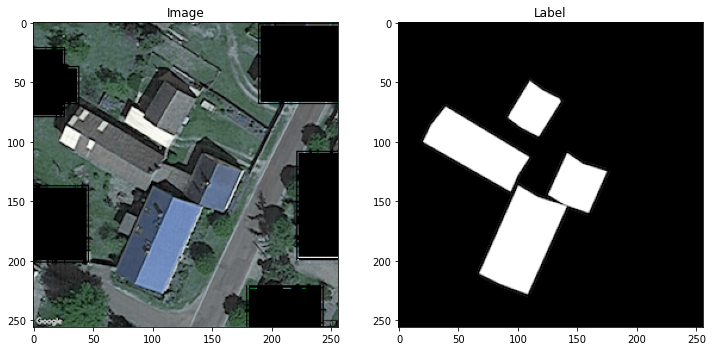

In [24]:
import random
t = random.randint(0,24)
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(X[t])
plt.title('Image')
plt.subplot(122)
plt.imshow(y_lb[t], cmap='gray')
plt.title('Label')
plt.show()

In [25]:
y_1 = np.full((25,256,256),0)
y = np.full((25,256,256,1),0)
matrix = np.full((25,256,256),0)
pmat = np.full((25,65536),0)
for i in range(0,25):
  mat = np.zeros(y_lb[i].size)
  mat2 = np.zeros(y_lb[i].size)
  flat_lb = y_lb[i].flatten()
  for j in range(0,y_lb[i].size):
    if flat_lb[j]>0.8:
      mat[j] = 1
    else:
      mat[j]=0
  mat2_2=mat2*255
  mat2_reshape = mat2_2.reshape(256,256)
  mat2_fin= np.expand_dims(mat2_reshape, axis = 2)
  pmat[i]=mat
  mat_reshape=mat.reshape(256,256)
  y[i]=mat2_fin
  matrix[i]=mat_reshape
for i in range(0,25):
  y[i]=np.expand_dims(matrix[i], axis = 2)

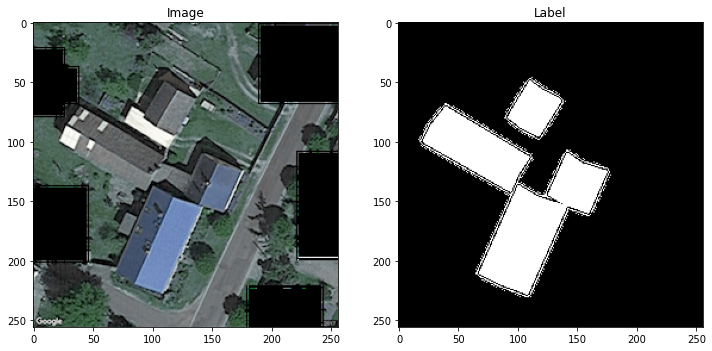

In [26]:
import random
t = random.randint(0,24)
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(X[24])
plt.title('Image')
plt.subplot(122)
plt.imshow(matrix[24], cmap='gray')
plt.title('Label')
plt.show()

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.08, random_state=1)
print(X_train.shape,'\n',y_train.shape, '\n',X_test.shape, '\n', y_test.shape)

(23, 256, 256, 3) 
 (23, 256, 256, 1) 
 (2, 256, 256, 3) 
 (2, 256, 256, 1)


In [38]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [29]:
# Build U-Net model
inputs = Input((256, 256, 3))
s = Lambda(lambda x: x / 255) (inputs) #normal to (0,1) images

#24 Conv2D
##ELU=Exponential linear unit(ELU)
#Glorot initialization -->he_normal initialization

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s) 
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

#encoder
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [41]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')#[mean_iou])
model.summary()
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=1, epochs=100)
mymodel=results.model    
print("The model is defined")

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_3 (Lambda)              (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 256, 256, 16  448         ['lambda_3[0][0]']               
                                )                                                                 
                                                                                            

In [42]:
#Predict on train, val and test
preds_train = mymodel.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = mymodel.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = mymodel.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



1/1 [==============================] - 0s 367ms/step


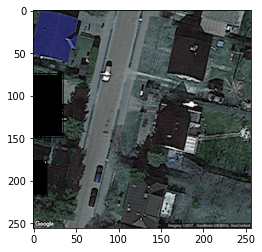

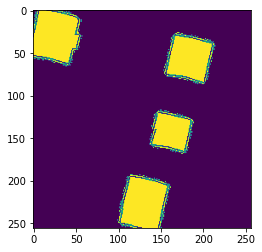

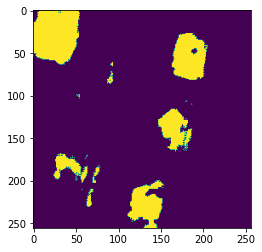

In [45]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[5])
plt.show();

imshow(np.squeeze(y_train[5]))
plt.show();
imshow(np.squeeze(preds_train_t[5]))
plt.show();
# print(mean_iou(Y_train[ix],preds_train_t[ix]))